In [1]:
import torch

In [2]:
import numpy as np
import cv2
from IPython.display import display, Image ,clear_output
import time
import keyboard
import mediapipe as mp
from transitions import Machine

In [3]:
class SpinAction():
    
    states = ['PAR','MID','VER','UNKNOWN']
    
    def __init__(self):
        
        self.cycle_count = 0
        
        self.machine = Machine(model = self, states =SpinAction.states, initial = 'UNKNOWN',ignore_invalid_triggers=True)
        
        self.machine.add_transition(trigger = 'unknown', source = 'UNKNOWN', dest = 'UNKNOWN') #1
        self.machine.add_transition(trigger = 'par', source = 'UNKNOWN', dest = 'PAR') #2
        self.machine.add_transition(trigger = 'mid', source = 'PAR', dest = 'MID') #3
        self.machine.add_transition(trigger = 'par', source = 'MID', dest = 'PAR') #4
        self.machine.add_transition(trigger = 'ver', source = 'MID', dest = 'VER') #5
        self.machine.add_transition(trigger = 'mid', source = 'VER', dest = 'MID') #6
        self.machine.add_transition(trigger = 'par', source = 'VER', dest = 'UNKNOWN', after = 'update_cycle_count') #7
        self.machine.add_transition(trigger = 'ver', source = 'VER', dest = 'UNKNOWN', after = 'update_cycle_count') #7
        self.machine.add_transition(trigger = 'mid', source = 'VER', dest = 'UNKNOWN', after = 'update_cycle_count') #7
        self.machine.add_transition(trigger = 'unknown', source = 'VER', dest = 'UNKNOWN', after = 'update_cycle_count') #7
        self.machine.add_transition(trigger = 'unknown', source = 'MID', dest = 'UNKNOWN') #8
    def update_cycle_count(self):
        self.cycle_count += 1

In [4]:
def findHands(img, draw=True):
        """
        Finds hands in a BGR image.
        :param img: Image to find the hands in.
        :param draw: Flag to draw the output on the image.
        :return: Image with or without drawings
        """
        results = hand.process(img)
        allHands = []
        h, w, c = img.shape
        if  results.multi_hand_landmarks:
            for handType,handLms in zip(results.multi_handedness,results.multi_hand_landmarks):
                myHand={}
                ## lmList
                mylmList = []
                xList = []
                yList = []
                for id, lm in enumerate(handLms.landmark):
                    px, py = int(lm.x * w), int(lm.y * h)
                    mylmList.append([px, py])
                    xList.append(px)
                    yList.append(py)

                ## bbox
                xmin, xmax = min(xList), max(xList)
                ymin, ymax = min(yList), max(yList)
                boxW, boxH = xmax - xmin, ymax - ymin
                bbox = xmin, ymin, boxW, boxH
                cx, cy = bbox[0] + (bbox[2] // 2), \
                         bbox[1] + (bbox[3] // 2)

                myHand["lmList"] = mylmList
                myHand["bbox"] = bbox
                myHand["center"] =  (cx, cy)

                
                if handType.classification[0].label =="Right":
                    myHand["type"] = "Left"
                else:
                    myHand["type"] = "Right"
                allHands.append(myHand)

                ## draw
                if draw:
                    mp_drawing.draw_landmarks(img, handLms,
                                               mp_hands.HAND_CONNECTIONS)
                    # cv2.rectangle(img, (bbox[0] - 20, bbox[1] - 20),
                    #               (bbox[0] + bbox[2] + 20, bbox[1] + bbox[3] + 20),
                    #               (255, 0, 255), 2)
                    # cv2.rectangle(img, (bbox[0], bbox[1]),
                    #               (bbox[0] + bbox[2], bbox[1] + bbox[3]),
                    #               (255, 0, 255), 2)
                    cv2.putText(img,myHand["type"],(bbox[0] - 30, bbox[1] - 30),cv2.FONT_HERSHEY_PLAIN,
                                2,(255, 0, 255),2)

            return allHands

In [5]:
def findPosition(allHands, img, handRL = 'Right' , landmarks_no = 0, draw=True):
    coordinate = []
    if allHands:
        for hand in allHands:
            if hand['type'] == handRL:
                x, y = hand['lmList'][landmarks_no][0], hand['lmList'][landmarks_no][1]
                coordinate.append(x)
                coordinate.append(y)
                if draw:
                    cv2.circle(img, (x, y), 5, (0, 255, 0), cv2.FILLED)
                    #cv2.putText(img, str(coordinate),(x, y), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    return coordinate

In [6]:
def findBbox(allHands, img, handRL = 'Right', draw=True):
    bbox = []
    if allHands:
        for hand in allHands:
            if hand['type'] == handRL:
                l = (hand["bbox"][0],hand["bbox"][1])
                r = (hand["bbox"][0] + hand["bbox"][2], hand["bbox"][1] + hand["bbox"][3])
                bbox.append(l)
                bbox.append(r)
                if draw:
                    cv2.rectangle(img, l, r,(255, 0, 255), 2)
    return bbox

In [7]:
def showVideo(img, fps=30):     
    _, en_image = cv2.imencode('.jpg',img)
    img_obj = Image(data = en_image)
    clear_output(True)
    display(img_obj)
    time.sleep(1/fps)

In [8]:
# Model
model = torch.hub.load('yolov5','custom', path='best1.pt',source='local')
#device = torch.device("cuda")
device = torch.device('cpu')
model.to(device)
print('ok')

YOLOv5  v6.0-255-gca0a007 torch 1.8.0 CPU

Fusing layers... 
Model Summary: 213 layers, 1760518 parameters, 0 gradients, 4.2 GFLOPs
Adding AutoShape... 


ok


In [9]:
def checkoverlap(point,x1,x2,y1,y2):
    check_result = None
    if point and x1 and x2 and y1 and y2:
        point_x = point[0]
        point_y = point[1]
        if x1 < point_x <x2 and y1 < point_y < y2:
            check_result = 'overlap'
        else:
            check_result = 'separate'
    return check_result

In [10]:
def penState(x1,x2,y1,y2):
    pen_state = None
    pen_width = abs(x1 - x2)
    pen_height = abs(y1 - y2)
    ratio = pen_height/pen_width
    if ratio >= 5:
        pen_state = 'pen_vertical'
    elif ratio < 5 and ratio > 1.5:
        pen_state = 'pen_mid'
    elif ratio<= 1.5:
        pen_state = 'pen_parallel'
    return pen_state

In [11]:
#https://stackoverflow.com/questions/306316/determine-if-two-rectangles-overlap-each-other
def calHandPenOverlap(A_X1,A_X2,A_Y1,A_Y2,B_X1,B_X2,B_Y1,B_Y2):
    if (A_X1 < B_X2 and A_X2 > B_X1 and A_Y1 < B_Y2 and A_Y2 > B_Y1):
        return True
    return False

In [12]:
def calGesture(right_index_finger_dip_overlap,right_index_finger_tip_overlap,right_middle_finger_dip_overlap,right_middle_finger_tip_overlap,\
            right_ring_finger_pip_overlap,right_pinky_pip_overlap,pen_state,right_hand_pen_overlap,left_hand_pen_overlap):
    gesture = None
    if ((right_index_finger_dip_overlap == 'overlap' or right_index_finger_tip_overlap == 'overlap'\
    or right_middle_finger_dip_overlap == 'overlap'or right_middle_finger_tip_overlap == 'overlap')\
    and (right_ring_finger_pip_overlap == 'separate' and right_pinky_pip_overlap == 'separate')\
    and pen_state == 'pen_vertical' and right_hand_pen_overlap == True and left_hand_pen_overlap == False):
        gesture = 'ver'
    
    elif ((right_index_finger_dip_overlap == 'overlap' or right_index_finger_tip_overlap == 'overlap'\
    or right_middle_finger_dip_overlap == 'overlap'or right_middle_finger_tip_overlap == 'overlap')\
    and (right_ring_finger_pip_overlap == 'separate' and right_pinky_pip_overlap == 'separate')\
    and pen_state == 'pen_parallel' and right_hand_pen_overlap == True and left_hand_pen_overlap == False):
        gesture = 'par'
        
    elif ((right_index_finger_dip_overlap == 'overlap' or right_index_finger_tip_overlap == 'overlap'\
    or right_middle_finger_dip_overlap == 'overlap'or right_middle_finger_tip_overlap == 'overlap')\
    and (right_ring_finger_pip_overlap == 'separate' and right_pinky_pip_overlap == 'separate')\
    and pen_state == 'pen_mid' and right_hand_pen_overlap == True and left_hand_pen_overlap == False):
        gesture = 'mid'
        
    else:
        gesture = 'unknown'
    
    return gesture    

In [12]:
#video = cv2.VideoCapture('C:/Users/Michael_Lee/Documents/Project_private/CGMH/EST2022/video_data/(001)spinning/OK.mp4')
# video = cv2.VideoCapture('C:/Users/Michael_Lee/Documents/Project_private/CGMH/EST2022/video_data/(001)spinning/NG1.mp4')
# classes = model.names
# model.conf = 0.5
# model.iou = 0.3
# colors = [(0,255,0), (0,255,0),(0,255,0),(0,255,0),(0,255,0),(0,255,0),(255,86,86),(255,86,86)]
# font = cv2.FONT_HERSHEY_SIMPLEX
# prev_frame_time = 0
# new_frame_time = 0
# count = 0
# # mp hand 實例
# mp_hands = mp.solutions.hands
# mp_drawing = mp.solutions.drawing_utils
# hand = mp_hands.Hands(max_num_hands=2, model_complexity=1, 
#                       min_detection_confidence=0.5,min_tracking_confidence=0.5)

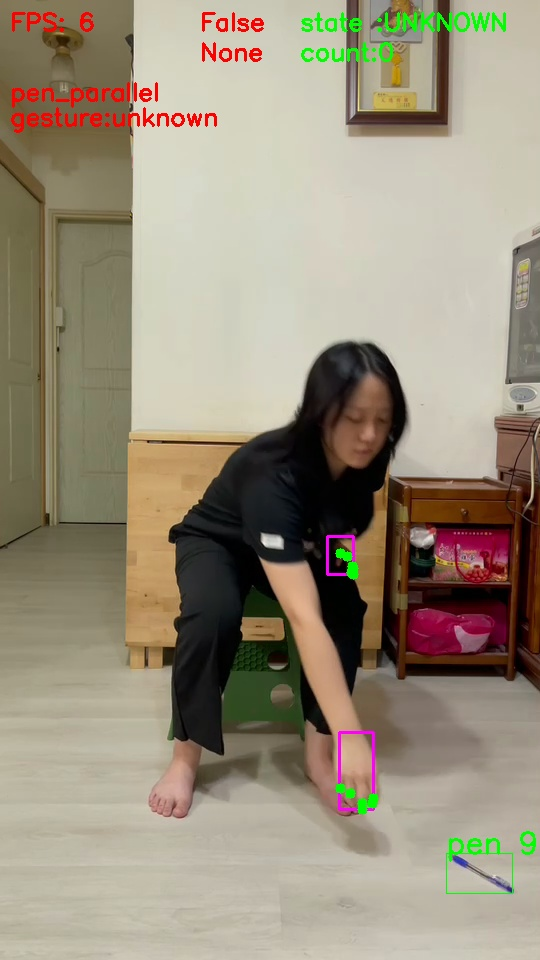

In [13]:
#video = cv2.VideoCapture('C:/Users/Michael_Lee/Documents/Project_private/CGMH/EST2022/video_data/(001)spinning/NG4.mp4')
video = cv2.VideoCapture('../../video_data/(001)spinning/NG4.mp4')
#video = cv2.VideoCapture('C:/Users/Michael_Lee/Documents/Project_private/CGMH/EST2022/video_data/(001)spinning/NG1.mp4')
classes = model.names
model.conf = 0.5
model.iou = 0.3
colors = [(0,255,0), (0,255,0),(0,255,0),(0,255,0),(0,255,0),(0,255,0),(255,86,86),(255,86,86)]
font = cv2.FONT_HERSHEY_SIMPLEX
prev_frame_time = 0
new_frame_time = 0
count = 0
# mp hand 實例
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hand = mp_hands.Hands(max_num_hands=2, model_complexity=1, 
                      min_detection_confidence=0.5,min_tracking_confidence=0.5)
# spining_action 實例
spin_action_detector = SpinAction()


while video.isOpened():
    ret, image = video.read()
    if ret == False:
        break
    height, width, _ = image.shape
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Detection pen
    pen = model(image, size=640)
    # Detection hand
    allHands = findHands(image, draw=0)
    
    # Find hand bbox
    right_hand_bbox = findBbox(allHands, image, handRL = 'Right', draw=True)
    left_hand_bbox = findBbox(allHands, image, handRL = 'Left', draw=True)
    
     # Find landmark coordinate
    right_index_finger_dip = findPosition(allHands, image, handRL = 'Right' , landmarks_no = 7 , draw=True)
    right_index_finger_tip = findPosition(allHands, image, handRL = 'Right' , landmarks_no = 8 , draw=True)
    right_middle_finger_dip = findPosition(allHands, image, handRL = 'Right' , landmarks_no = 11 , draw=True)
    right_middle_finger_tip = findPosition(allHands, image, handRL = 'Right' , landmarks_no = 12 , draw=True)
    right_ring_finger_pip = findPosition(allHands, image, handRL = 'Right' , landmarks_no = 14 , draw=True)
    right_pinky_pip = findPosition(allHands, image, handRL = 'Right' , landmarks_no = 18 , draw=True)
        
   # Draw pen bbox
    labels, bbox = pen.xyxyn[0][:,-1], pen.xyxyn[0][:,:-1]
    if len(labels) == 1:
        x1, y1 = bbox[0][0].item()*width, bbox[0][1].item()*height
        x2, y2 = bbox[0][2].item()*width, bbox[0][3].item()*height
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        label = classes[int(labels[0])]
        probability = int(bbox[0][4].item()*100)
        cv2.rectangle(image, (x1,y1), (x2,y2), colors[int(labels[0])], 1)
        cv2.putText(image,  label +" "+str(probability)+"%", (x1,y1), font, 1, colors[int(labels[0])],2)

    # Cal pen state 
    pen_state = None
    pen_state = penState(x1,x2,y1,y2)
    cv2.putText(image, str(pen_state), (10,100), font, 0.8, (255,0,0),2)

    #check finger_pen_overlap
    right_index_finger_dip_overlap = checkoverlap(right_index_finger_dip,x1,x2,y1,y2)
    right_index_finger_tip_overlap = checkoverlap(right_index_finger_tip,x1,x2,y1,y2)
    right_middle_finger_dip_overlap = checkoverlap(right_middle_finger_dip,x1,x2,y1,y2)
    right_middle_finger_tip_overlap = checkoverlap(right_middle_finger_tip,x1,x2,y1,y2)
    right_ring_finger_pip_overlap = checkoverlap(right_ring_finger_pip,x1,x2,y1,y2)
    right_pinky_pip_overlap = checkoverlap(right_pinky_pip,x1,x2,y1,y2)

    # Cal hand pen overlap
    right_hand_pen_overlap = None
    left_hand_pen_overlap = None
    if right_hand_bbox:
        right_hand_pen_overlap = calHandPenOverlap(right_hand_bbox[0][0],right_hand_bbox[1][0],right_hand_bbox[0][1],right_hand_bbox[1][1],x1,x2,y1,y2)
    if left_hand_bbox:
        left_hand_pen_overlap = calHandPenOverlap(left_hand_bbox[0][0],left_hand_bbox[1][0],left_hand_bbox[0][1],left_hand_bbox[1][1],x1,x2,y1,y2)
    cv2.putText(image, str(right_hand_pen_overlap), (200,30), font, 0.8, (255,0,0),2)
    cv2.putText(image, str(left_hand_pen_overlap), (200,60), font, 0.8, (255,0,0),2)

    # Cal gesture
    gesture = None
    gesture = calGesture(right_index_finger_dip_overlap,right_index_finger_tip_overlap,right_middle_finger_dip_overlap,right_middle_finger_tip_overlap,\
        right_ring_finger_pip_overlap,right_pinky_pip_overlap,pen_state,right_hand_pen_overlap,left_hand_pen_overlap)
    cv2.putText(image, 'gesture:'+ str(gesture), (10,125), font, 0.8, (255,0,0),2)
    
    # spin action fsm
    if gesture == 'unknown':
        spin_action_detector.unknown()
    elif gesture == 'par':
        spin_action_detector.par()
    elif gesture == 'ver':
        spin_action_detector.ver()
    elif gesture == 'mid':
        spin_action_detector.mid()
     
    
        
    cv2.putText(image,'state :'+str(spin_action_detector.state), (300,30), font, 0.8, (0,  255, 0), 2)
    cv2.putText(image, ('count:'+str(spin_action_detector.cycle_count)), (300,60), font, 0.8, (0,  255, 0), 2) 
        
    
                                                      
    # Show fps
    new_frame_time = time.time()
    fps = 1 / (new_frame_time - prev_frame_time)
    prev_frame_time = new_frame_time
    cv2.putText(image, "FPS: "+str(int(fps)), (10,30), font, 0.8, (255,0,0),2)
    
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    showVideo(image, fps=30)
    count+=1
    if keyboard.is_pressed('esc'):
        video.release()
        break
video.release()